In [20]:
import pandas as pd

# Dataset Loading

In [21]:
df = pd.read_csv("fraudTest.csv")
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [22]:
df.shape

(555719, 23)

In [23]:
df = df.drop(['Unnamed: 0','trans_num','merch_lat',"merch_long"], axis=1)

In [24]:
df.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'unix_time', 'is_fraud'],
      dtype='object')

In [25]:
df["is_fraud"].value_counts()

0    553574
1      2145
Name: is_fraud, dtype: int64

As we can see that the data is heavily imbalanced so downscale to balance it.

# Data Preprocessing

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import joblib
from datetime import datetime



# Convert 'trans_date_trans_time' to datetime and extract features
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['year'] = df['trans_date_trans_time'].dt.year
df['month'] = df['trans_date_trans_time'].dt.month
df['day'] = df['trans_date_trans_time'].dt.day
df['hour'] = df['trans_date_trans_time'].dt.hour
df['weekday'] = df['trans_date_trans_time'].dt.weekday

# Convert 'dob' to datetime and calculate age
df['dob'] = pd.to_datetime(df['dob'])
current_year = datetime.now().year
df['age'] = current_year - df['dob'].dt.year

# Drop the original datetime columns as they're now redundant
df.drop(['trans_date_trans_time', 'dob'], axis=1, inplace=True)

# Handling categorical data
categorical_columns = ['merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'job']
encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le
    joblib.dump(le, f'encoders/{col}_encoder.pkl')  # Save each encoder to disk

# Balancing the data
df_majority = df[df['is_fraud'] == 0]
df_minority = df[df['is_fraud'] == 1]
df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=42)
df_balanced = pd.concat([df_minority, df_majority_downsampled]).sample(frac=1, random_state=42)

# Splitting the dataset into training and testing sets
X = df_balanced.drop('is_fraud', axis=1)
y = df_balanced['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
X_train.columns

Index(['cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender',
       'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job',
       'unix_time', 'year', 'month', 'day', 'hour', 'weekday', 'age'],
      dtype='object')

In [28]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import joblib

# Initialize models
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    proba_predictions = model.predict_proba(X_test)[:, 1]  # Probability estimates for ROC AUC
    results[name] = {
        'Accuracy': accuracy_score(y_test, predictions),
        'ROC AUC': roc_auc_score(y_test, proba_predictions),
        'Classification Report': classification_report(y_test, predictions)
    }

# Print the evaluation results
for model_name, metrics in results.items():
    print(f"Results for {model_name}:")
    print(f"Accuracy: {metrics['Accuracy']}")
    print(f"ROC AUC: {metrics['ROC AUC']}")
    print("Classification Report:")
    print(metrics['Classification Report'])
    print("\n")

Results for RandomForest:
Accuracy: 0.9463869463869464
ROC AUC: 0.986357038398182
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       439
           1       0.95      0.94      0.94       419

    accuracy                           0.95       858
   macro avg       0.95      0.95      0.95       858
weighted avg       0.95      0.95      0.95       858



Results for GradientBoosting:
Accuracy: 0.9428904428904429
ROC AUC: 0.9823312910117918
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       439
           1       0.94      0.94      0.94       419

    accuracy                           0.94       858
   macro avg       0.94      0.94      0.94       858
weighted avg       0.94      0.94      0.94       858



Results for LogisticRegression:
Accuracy: 0.5116550116550117
ROC AUC: 0.5313959367405853
Classification Report:
              p

C:\Users\nikhi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nikhi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nikhi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### As we can see from results, Random Forest out performs all other models, so lets move forward with that.

In [29]:
# Training the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [30]:
# Evaluating the model
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       439
           1       0.95      0.94      0.94       419

    accuracy                           0.95       858
   macro avg       0.95      0.95      0.95       858
weighted avg       0.95      0.95      0.95       858



In [31]:
# Saving the model
joblib.dump(model, 'fraud_detection_model.pkl')

['fraud_detection_model.pkl']

# Evaluation and Visualizations

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns 

## Classification Report

In [33]:
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       439
           1       0.95      0.94      0.94       419

    accuracy                           0.95       858
   macro avg       0.95      0.95      0.95       858
weighted avg       0.95      0.95      0.95       858



## Confusion Matrix

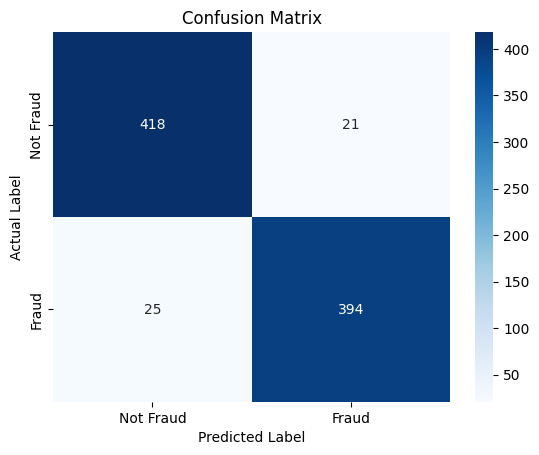

In [34]:
conf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

## Accuracy Score

In [35]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 94.64%


## ROC Curve and AUC

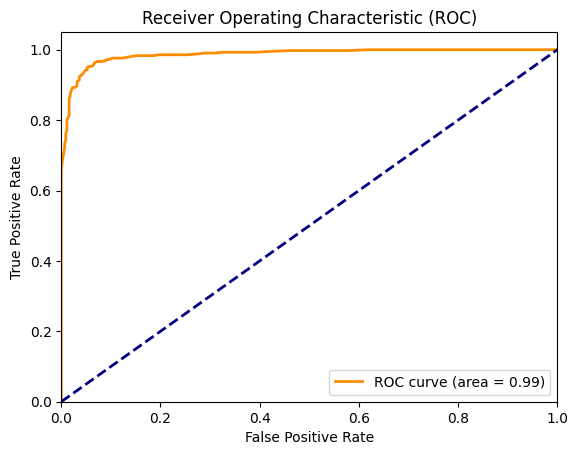

In [36]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()